In [ ]:
# /// script
# requires-python = ">=3.13"
# dependencies = [
#     "duckdb",
#     "jupyterlab",
#     "pandas",
#     "plotly",
# ]
#
# [tool.uv]
# exclude-newer = "2025-12-29T09:27:12.558381-08:00"
# ///

# Yardstick + DuckDB: Looker-style measures

This notebook builds a small ecommerce dataset, defines measures with Yardstick, and runs Looker-style analyses: percent of total, filtered totals, YoY, and drill-downs.

Run from the repo root with juv:

```bash
# optional install
uv tool install juv

# run (no install)
uvx juv run docs/yardstick_looker_demo.ipynb
# or
juv run docs/yardstick_looker_demo.ipynb
```

If the local extension is built, the notebook loads it from `build/release/extension/yardstick/yardstick.duckdb_extension`. Otherwise it falls back to `INSTALL yardstick FROM community`.


In [1]:
from pathlib import Path
import duckdb
import pandas as pd
import plotly.express as px
from IPython.display import display

conn = duckdb.connect(database=":memory:", config={"allow_unsigned_extensions": "true"})

ext_path = Path("build/release/extension/yardstick/yardstick.duckdb_extension").resolve()
if ext_path.exists():
    conn.execute(f"LOAD '{ext_path.as_posix()}'")
else:
    conn.execute("INSTALL yardstick FROM community")
    conn.execute("LOAD yardstick")

def exec_sql(sql: str) -> None:
    conn.execute(sql)

def df_sql(sql: str) -> pd.DataFrame:
    return conn.sql(sql).df()


## Create sample data

Deterministic data with 2 years of orders, region, channel, and category.


In [2]:
exec_sql("""
create or replace table orders as
with seed as (
    select
        order_id,
        date '2023-01-01' + (order_id % 730)::integer as order_date,
        case
            when order_id % 4 = 0 then 'North'
            when order_id % 4 = 1 then 'South'
            when order_id % 4 = 2 then 'East'
            else 'West'
        end as region,
        case
            when order_id % 3 = 0 then 'Online'
            when order_id % 3 = 1 then 'Retail'
            else 'Partner'
        end as channel,
        case
            when order_id % 5 = 0 then 'Hardware'
            when order_id % 5 = 1 then 'Software'
            when order_id % 5 = 2 then 'Accessories'
            when order_id % 5 = 3 then 'Services'
            else 'Support'
        end as category,
        1 + (order_id % 5) as quantity,
        1 + (order_id % 800) as customer_id
    from range(1, 2401) t(order_id)
),
dated as (
    select
        *,
        extract(year from order_date) as year,
        extract(month from order_date) as month
    from seed
),
priced as (
    select
        *,
        case category
            when 'Hardware' then 120 + (order_id % 80)
            when 'Software' then 60 + (order_id % 50)
            when 'Accessories' then 25 + (order_id % 20)
            when 'Services' then 90 + (order_id % 40)
            else 30 + (order_id % 25)
        end as unit_price,
        case
            when month in (11, 12) then 1.2
            when month in (6, 7) then 1.08
            when month in (3, 4) then 0.97
            else 1.0
        end as seasonality
    from dated
)
select
    order_id,
    order_date,
    year,
    month,
    region,
    channel,
    category,
    quantity,
    unit_price,
    round(quantity * unit_price * seasonality, 2) as revenue,
    customer_id
from priced;
""")


In [3]:
display(df_sql("select * from orders limit 8"))


,order_id,order_date,year,month,region,channel,category,quantity,unit_price,revenue,customer_id
0,1,2023-01-02,2023,1,South,Retail,Software,2,61,122.0,2
1,2,2023-01-03,2023,1,East,Partner,Accessories,3,27,81.0,3
2,3,2023-01-04,2023,1,West,Online,Services,4,93,372.0,4
3,4,2023-01-05,2023,1,North,Retail,Support,5,34,170.0,5
4,5,2023-01-06,2023,1,South,Partner,Hardware,1,125,125.0,6
5,6,2023-01-07,2023,1,East,Online,Software,2,66,132.0,7
6,7,2023-01-08,2023,1,West,Retail,Accessories,3,32,96.0,8
7,8,2023-01-09,2023,1,North,Partner,Services,4,98,392.0,9


## Define measures

Measures live in views. Yardstick handles the grouping.


In [4]:
exec_sql("""
create or replace view orders_v as
select
    year,
    month,
    region,
    channel,
    category,
    sum(revenue) as measure revenue,
    count(*) as measure orders
from orders;

create or replace view orders_online_2024_v as
select
    category,
    sum(revenue) as measure revenue
from orders
where year = 2024 and channel = 'Online';
""")


## KPI overview


In [5]:
display(df_sql("""
SEMANTIC SELECT
    'All' as scope,
    aggregate(revenue) as revenue,
    aggregate(orders) as orders,
    aggregate(revenue) / aggregate(orders) as aov
from orders_v as _outer;
"""))


,scope,revenue,orders,aov
0,All,543530.97,1276,425.96471


## Revenue by region and percent of total


In [6]:
display(df_sql("""
SELECT
    _outer.region,
    aggregate(revenue) as revenue,
    100.0 * aggregate(revenue) / aggregate(revenue) at (all) as pct_total
from orders_v as _outer
order by revenue desc;
"""))


,region,revenue,pct_total
0,South,138988.27,25.571362
1,East,137768.60,25.346964
2,North,135297.35,24.892298
3,West,131476.75,24.189376


,region,revenue,pct_total,pct_total_label
0,South,138988.27,25.571362,25.6%
1,East,137768.60,25.346964,25.3%
2,North,135297.35,24.892298,24.9%
3,West,131476.75,24.189376,24.2%


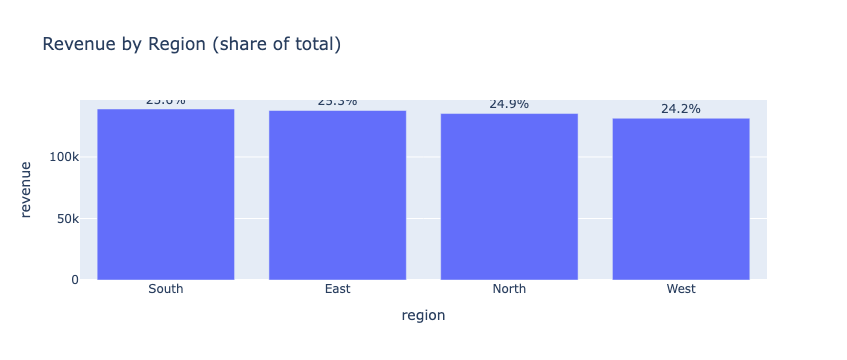

In [7]:
region_df = df_sql("""
SELECT
    _outer.region,
    aggregate(revenue) as revenue,
    100.0 * aggregate(revenue) / aggregate(revenue) at (all) as pct_total
from orders_v as _outer
order by revenue desc;
""")
region_df["pct_total_label"] = region_df["pct_total"].map(lambda v: f"{float(v):.1f}%")
display(region_df)
fig = px.bar(
    region_df,
    x="region",
    y="revenue",
    text="pct_total_label",
    title="Revenue by Region (share of total)"
)
fig.update_traces(textposition="outside")
fig.show()


## Share within year


In [8]:
display(df_sql("""
SELECT
    _outer.year,
    _outer.region,
    aggregate(revenue) as revenue,
    100.0 * aggregate(revenue) / aggregate(revenue) at (all region) as pct_of_year
from orders_v as _outer
order by year, revenue desc;
"""))


,year,region,revenue,pct_of_year
0,2023,South,75422.46,25.558945
1,2023,East,74828.95,25.357818
2,2023,North,73286.70,24.835185
3,2023,West,71554.12,24.248053
4,2024,South,63565.81,25.586110
5,2024,East,62939.65,25.334072
6,2024,North,62010.65,24.960137
7,2024,West,59922.63,24.119680


## Channel mix within region


In [9]:
display(df_sql("""
SELECT
    _outer.year,
    _outer.region,
    _outer.channel,
    aggregate(revenue) as revenue,
    100.0 * aggregate(revenue) / aggregate(revenue) at (all channel) as channel_share
from orders_v as _outer
order by year, region, revenue desc;
"""))


,year,region,channel,revenue,channel_share
0,2023,East,Retail,25290.30,33.797481
1,2023,East,Partner,24981.30,33.384539
2,2023,East,Online,24557.35,32.817980
3,2023,North,Online,25001.05,34.114034
4,2023,North,Partner,24288.45,33.141689
5,2023,North,Retail,23997.20,32.744277
6,2023,South,Retail,25165.80,33.366453
7,2023,South,Partner,25148.46,33.343463
8,2023,South,Online,25108.20,33.290084
9,2023,West,Partner,23940.25,33.457542


## Year over year growth


In [10]:
display(df_sql("""
SELECT
    _outer.region,
    aggregate(revenue) at (set year = 2024) as rev_2024,
    aggregate(revenue) at (set year = 2023) as rev_2023,
    aggregate(revenue) at (set year = 2024) - aggregate(revenue) at (set year = 2023) as yoy_change,
    100.0 * (aggregate(revenue) at (set year = 2024) - aggregate(revenue) at (set year = 2023))
        / nullif(aggregate(revenue) at (set year = 2023), 0) as yoy_pct
from orders_v as _outer
order by yoy_change desc;
"""))


,region,rev_2024,rev_2023,yoy_change,yoy_pct
0,North,62010.65,73286.70,-11276.05,-15.386216
1,West,59922.63,71554.12,-11631.49,-16.255514
2,South,63565.81,75422.46,-11856.65,-15.720317
3,East,62939.65,74828.95,-11889.30,-15.888637


,region,rev_2024,rev_2023,yoy_change,yoy_pct,yoy_pct_label
0,North,62010.65,73286.70,-11276.05,-15.386216,-15.4%
1,West,59922.63,71554.12,-11631.49,-16.255514,-16.3%
2,South,63565.81,75422.46,-11856.65,-15.720317,-15.7%
3,East,62939.65,74828.95,-11889.30,-15.888637,-15.9%


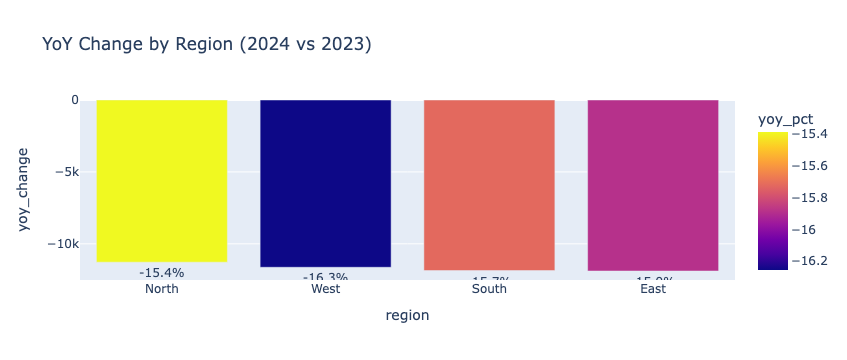

In [11]:
yoy_df = df_sql("""
SELECT
    _outer.region,
    aggregate(revenue) at (set year = 2024) as rev_2024,
    aggregate(revenue) at (set year = 2023) as rev_2023,
    aggregate(revenue) at (set year = 2024) - aggregate(revenue) at (set year = 2023) as yoy_change,
    100.0 * (aggregate(revenue) at (set year = 2024) - aggregate(revenue) at (set year = 2023))
        / nullif(aggregate(revenue) at (set year = 2023), 0) as yoy_pct
from orders_v as _outer
order by yoy_change desc;
""")
yoy_df["yoy_pct_label"] = yoy_df["yoy_pct"].map(lambda v: f"{float(v):.1f}%")
display(yoy_df)
fig = px.bar(
    yoy_df,
    x="region",
    y="yoy_change",
    color="yoy_pct",
    text="yoy_pct_label",
    title="YoY Change by Region (2024 vs 2023)"
)
fig.update_traces(textposition="outside")
fig.show()


## Drill-down: Online categories in 2024

Uses a filtered view plus `AT (ALL category)` to compute share within the slice.


In [12]:
display(df_sql("""
SELECT
    _outer.category,
    aggregate(revenue) as revenue,
    100.0 * aggregate(revenue) / aggregate(revenue) at (all category) as pct_of_filtered
from orders_online_2024_v as _outer
order by revenue desc;
"""))


,category,revenue,pct_of_filtered
0,Services,33558.80,40.585350
1,Support,16655.75,20.143135
2,Software,12701.40,15.360822
3,Hardware,11902.45,14.394588
4,Accessories,7868.58,9.516105


## Compare a slice to total with WHERE

`AT (WHERE ...)` calculates a measure with an extra filter.


In [13]:
display(df_sql("""
SELECT
    'All' as scope,
    aggregate(revenue) as revenue,
    aggregate(revenue) at (where channel = 'Online') as online_revenue,
    100.0 * aggregate(revenue) at (where channel = 'Online') / aggregate(revenue) as online_share
from orders_v as _outer;
"""))


,scope,revenue,online_revenue,online_share
0,All,543530.97,181175.64,33.333085
